In [49]:
import torch
import torch.nn as nn

In [50]:
class Resblock3D(nn.Module):
    def __init__(self,in_ch,out_ch,t_emb_dim):
        super().__init__()

        self.time_mlp = nn.Linear(t_emb_dim,out_ch)

        self.conv1 = nn.Sequential(
            nn.Conv3d(in_ch,out_ch,kernel_size=(1,3,3), padding=(0,1,1)),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(),
            nn.Conv3d(out_ch,out_ch,kernel_size=(3,1,1), padding=(1,0,0))
        )
        self.conv2 = nn.Sequential(
            nn.BatchNorm3d(out_ch),
            nn.ReLU(),
            nn.Conv3d(out_ch,out_ch,kernel_size=(1,3,3), padding=(0,1,1)),
            nn.Conv3d(out_ch,out_ch,kernel_size=(3,1,1), padding=(1,0,0))
        )
        self.reLU=nn.ReLU()
        self.res_conv = nn.Conv3d(in_ch, out_ch,1) if in_ch != out_ch else nn.Identity()

    def forward(self,x,t):
        h= self.conv1(x)
        h+= self.time_mlp(t)[:,:,None,None,None]
        h= self.conv2(h)
        return self.reLU(h+self.res_conv(x))

In [51]:
class tiny3Dunet(nn.Module):
    def __init__(self):
        super().__init__()
        t_dim=256

        self.time_mlp = nn.Sequential(
            nn.Linear(1,t_dim),
            nn.ReLU(),
            nn.Linear(t_dim,t_dim)
        )

        self.inc = nn.Conv3d(2,32,kernel_size=3,padding=1)
        self.down1 = Resblock3D(32,64,t_dim)
        self.pool = nn.MaxPool3d(kernel_size=(1,2,2))
        self.down2 = Resblock3D(64,128,t_dim)

        self.mid = Resblock3D(128,128,t_dim)

        self.up = nn.Upsample(scale_factor=(1,2,2),mode='trilinear',align_corners=False)
        self.up_block1 = Resblock3D(256,64,t_dim)
        self.up_block2 = Resblock3D(128,32,t_dim)

        self.outc = nn.Conv3d(32,1,kernel_size=1)
    def forward(self,x,t):
        t= t.float().view(-1,1)
        t_emb= self.time_mlp(t)

        x0=self.inc(x)
        x1=self.down1(x0,t_emb)
        p1=self.pool(x1)

        x2=self.down2(p1,t_emb)
        p2=self.pool(x2)

        m= self.mid(p2,t_emb)

        u1=self.up(m)
        u1=torch.cat([u1,x2],dim=1)
        u1=self.up_block1(u1,t_emb)

        u2=self.up(u1)
        u2=torch.cat([u2,x1],dim=1)
        u2=self.up_block2(u2,t_emb)

        return self.outc(u2) 

In [52]:
T=1000
beta=torch.linspace(1e-4,0.02,T)
alpha=1-beta
alpha_bar=torch.cumprod(alpha,dim=0)
def q_sample(x0,t,noise=None):
    if noise is None:
        noise=torch.randn_like(x0)
    device=x0.device
    alpha_bar=torch.cumprod(alpha,dim=0).to(device)
    alpha_bart=alpha_bar[t][(...,)+ (None,)*4]
    return torch.sqrt(alpha_bart)*x0+torch.sqrt(1-alpha_bart)*noise

In [53]:
def p_loss_3d(denoise_model, x_start, t, noise=None):
    if noise is None:
        noise=torch.randn_like(x_start)
    
    # Take the first frame as a condition
    condition = x_start[:,:,-1,:,:].unsqueeze(2).repeat(1,1,16,1,1)

    # Add noise to the video (Forward)
    x_noisy= q_sample(x_start,t,noise)

    # Concatenate noise and condition to feed it as input
    model_input = torch.cat([x_noisy,condition], dim=1)

    # predicted noise
    predicted_noise = denoise_model(model_input,t)

    # MSE Loss
    return torch.nn.functional.mse_loss(predicted_noise,noise)

In [54]:
model = tiny3Dunet() # Ensure you updated self.inc to 2 channels

# Batch of real videos
real_video = torch.randn(2, 1, 16, 28, 28)
t = torch.randint(0, 1000, (2,))

loss = p_loss_3d(model, real_video, t)
print(f"Loss: {loss.item()}")

Loss: 1.0383415222167969


In [55]:
from scipy.ndimage import distance_transform_edt
from torch.utils.data import Dataset,DataLoader
import numpy as np
from torchvision import datasets, transforms

In [56]:
class DirectionalMNISTDataset(Dataset):
    def __init__(self, train=True):
        self.mnist = datasets.MNIST(
            root="./data", 
            train=train, 
            download=True, 
            transform=transforms.ToTensor()
        )
        
    def __len__(self):
        return len(self.mnist)
    
    def simulate_motion(self, image_tensor):
        # 1. Prepare Base Image
        img_np = image_tensor.squeeze().numpy()
        binary = (img_np > 0.5).astype(np.float32)
        
        # 2. Calculate Structure (Distance Transform)
        # Higher value = Deeper inside the digit
        dist_map = distance_transform_edt(binary)
        
        # 3. Calculate Direction (Vertical Gradient)
        # Create a grid where Top = 1.0, Bottom = 0.0
        h, w = dist_map.shape
        y_coords = np.linspace(1.0, 0.0, h) # Linear gradient
        # Broadcast to (28, 28)
        vertical_gradient = np.tile(y_coords[:, None], (1, w))
        
        # 4. Combine: Priority Score
        # We multiply dist_map by the gradient.
        # Top-Center pixels get HIGHEST score (Appear first)
        # Bottom-Edge pixels get LOWEST score (Appear last)
        # Adding a small constant (+0.1) ensures we don't kill the signal completely at the bottom
        priority_map = dist_map * (vertical_gradient + 0.5) 
        
        # Mask out background (0 stays 0)
        priority_map = priority_map * binary
        
        # 5. Create 16 Frames
        frames = []
        max_val = priority_map.max() + 1e-5
        
        for i in range(16):
            # Reverse loop: We want Frame 0 to be the "Full" image (Low Threshold)
            # Frame 15 to be the "Start" (High Threshold)
            # Wait! In our logic:
            # Frame 0 = Input Condition (Full Digit)
            # Frame 15 = Pure Noise / Empty
            
            # Let's align with your training logic:
            # We want the dataset to provide a sequence where:
            # Frame 0 = Faint/Partial (Start of writing)
            # Frame 15 = Full Digit (End of writing)
            # (The model learns to denoise towards the full digit)
            
            # Threshold goes from High (only top-center visible) to Low (everything visible)
            thresh = (1.0 - (i / 15.0)) * max_val 
            
            frame = (priority_map > thresh).astype(np.float32)
            frames.append(frame)
            
        return torch.tensor(np.array(frames)).unsqueeze(0), img_np

    def __getitem__(self, idx):
        static_img, label = self.mnist[idx]
        video, raw_img = self.simulate_motion(static_img)
        
        # Normalize to [-1, 1]
        return (video * 2) - 1, label

Video Shape: torch.Size([1, 16, 28, 28])


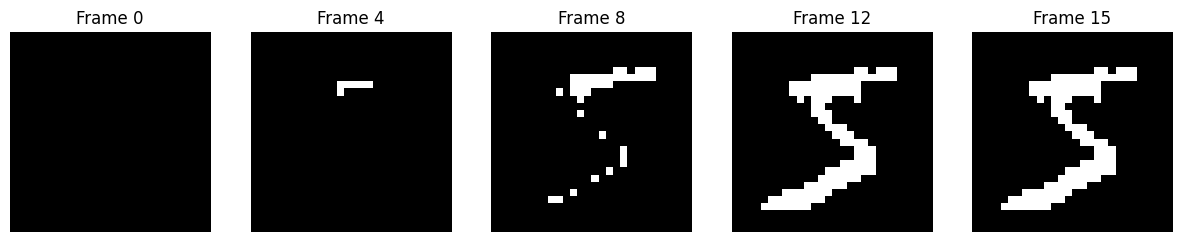

In [57]:
import matplotlib.pyplot as plt

ds = DirectionalMNISTDataset(train=True)
video, label = ds[0] # Get a sample

print(f"Video Shape: {video.shape}")

# Plot frames 0, 4, 8, 12, 15
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
indices = [0, 4, 8, 12, 15]

for i, idx in enumerate(indices):
    frame = video[0, idx]
    axes[i].imshow(frame, cmap='gray')
    axes[i].set_title(f"Frame {idx}")
    axes[i].axis('off')

plt.show()

In [58]:
import torch.optim as optim
from tqdm import tqdm

In [59]:
torch.backends.cudnn.benchmark = True

In [60]:
# --- 1. Setup ---
# Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 2e-4
epochs = 3
batch_size = 64 

# Initialize Components
model = tiny3Dunet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = p_loss_3d # Your custom 3D loss

# Dataset
ds = DirectionalMNISTDataset(train=True)
train_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# --- 2. Training Loop ---
print("Starting 3D Training...")
losses = []

for epoch in range(epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    
    for batch_video, _ in pbar:
        # batch_video shape: (B, 1, 16, 28, 28)
        batch_video = batch_video.to(device)
        
        # Random Timesteps
        t = torch.randint(0, 1000, (batch_video.shape[0],), device=device).long()
        
        # Calculate Loss
        loss = criterion(model, batch_video, t)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging
        losses.append(loss.item())
        pbar.set_postfix(MSE=loss.item())

# --- 3. Save the Model ---
torch.save(model.state_dict(), "mnist_motion_3d_v3.pth")
print("Training Complete! Model Saved.")

Starting 3D Training...


Epoch 3/3: 100%|██████████| 938/938 [06:06<00:00,  2.56it/s, MSE=0.0656]

Training Complete! Model Saved.


In [66]:
@torch.no_grad()
def ddpm_reverse_step_3d(model, x, t, condition):
    # Ensure schedules are on the same device as x
    # It is more efficient to move these once outside the loop, 
    # but doing it here ensures it never crashes.
    dev = x.device
    
    # 1. Get constants and move to device
    alpha_t = alpha.to(dev)[t][(...,) + (None,) * 4]
    alpha_bar_t = alpha_bar.to(dev)[t][(...,) + (None,) * 4]
    beta_t = beta.to(dev)[t][(...,) + (None,) * 4]
    
    # 2. Predict noise
    model_input = torch.cat([x, condition], dim=1)
    eps_theta = model(model_input, t)
    
    # 3. Diffusion math
    mean = (1 / torch.sqrt(alpha_t)) * (
        x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * eps_theta
    )
    
    if t > 0:
        z = torch.randn_like(x)
        return mean + torch.sqrt(beta_t) * z
    else:
        return mean

In [67]:
# Move these to GPU once
alpha = alpha.to(device)
alpha_bar = alpha_bar.to(device)
beta = beta.to(device)

In [68]:
# Re-initialize the model structure
model = tiny3Dunet().to(device)

# Load the trained weights
model.load_state_dict(torch.load("mnist_motion_3d_v3.pth", map_location=device))
model.eval() # Set to evaluation mode
print("Model loaded successfully.")

Model loaded successfully.


In [71]:
import matplotlib.pyplot as plt

@torch.no_grad()
def generate_writing_sample(model, digit_index=None):
    # 1. Get a Test Image
    test_ds = DirectionalMNISTDataset(train=False)
    
    if digit_index is None:
        # Search for a "7" because it draws top-down clearly
        for i in range(len(test_ds)):
            _, label = test_ds[i]
            if label == 7:
                digit_index = i
                break
    
    # Get the sample (video, raw_image) - we only need the raw image for conditioning
    # Note: DirectionalMNISTDataset returns (video, label), but inside it calculates raw_img
    # Let's just grab the tensor from the dataset directly
    video_tensor, label = test_ds[digit_index]
    
    # Extract Frame 0 (The Full Digit) to use as condition
    # video_tensor shape: (1, 16, 28, 28) -> We want (1, 28, 28)
    # In our new dataset logic, Frame 15 is the "Start" (empty) and Frame 0 is "Full".
    # Wait! The dataset logic was: Frame 0 = Full (Low Threshold).
    # So we take Frame 0 as the reference.
    ref_frame = video_tensor[:,-1, :, :].to(device)
    
    # 2. Prepare Condition (Repeat 16 times)
    condition = ref_frame.unsqueeze(1).repeat(1, 16, 1, 1).unsqueeze(0) # (1, 1, 16, 28, 28)
    
    # 3. Start from Noise
    x = torch.randn((1, 1, 16, 28, 28)).to(device)
    
    # 4. Denoise Loop
    # Move schedules to GPU once
    alpha_gpu = alpha.to(device)
    alpha_bar_gpu = alpha_bar.to(device)
    beta_gpu = beta.to(device)

    print(f"Generating animation for Digit {label}...")
    
    for i in tqdm(reversed(range(1000)), total=1000, desc="Writing"):
        t = torch.tensor([i]).to(device)
        
        # --- DDPM Step ---
        # 1. Predict Noise
        model_input = torch.cat([x, condition], dim=1)
        eps_theta = model(model_input, t)
        
        # 2. Calculate Mean
        # Broadcast schedules to (B, 1, 1, 1, 1)
        a_t = alpha_gpu[i].view(1,1,1,1,1)
        ab_t = alpha_bar_gpu[i].view(1,1,1,1,1)
        b_t = beta_gpu[i].view(1,1,1,1,1)
        
        mean = (1 / torch.sqrt(a_t)) * (x - (b_t / torch.sqrt(1 - ab_t)) * eps_theta)
        
        if i > 0:
            z = torch.randn_like(x)
            x = mean + torch.sqrt(b_t) * z
        else:
            x = mean

    # 5. Format Output
    # Reverse frames so it plays from Empty -> Full
    # generated video is (1, 1, 16, 28, 28)
    output = x.clamp(-1, 1).cpu().squeeze().numpy()
    return output, ref_frame.cpu().squeeze().numpy()

# Run it
generated_video, ref_image = generate_writing_sample(model)

Generating animation for Digit 7...


Writing: 100%|██████████| 1000/1000 [00:04<00:00, 239.59it/s]


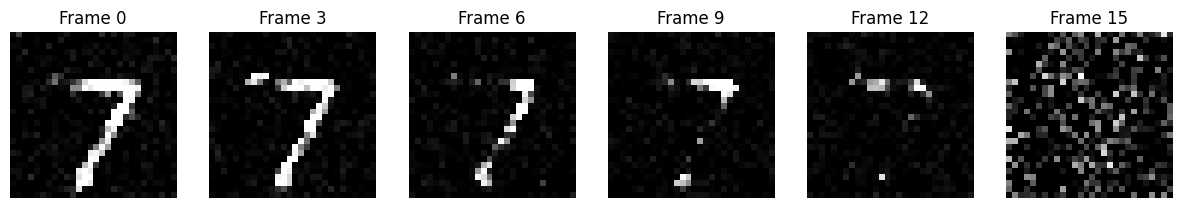

In [72]:
# We reverse the output for playback (Start -> Finish)
display_video = generated_video[::-1]

fig, axes = plt.subplots(1, 6, figsize=(15, 3))
indices = [0, 3, 6, 9, 12, 15]

for i, idx in enumerate(indices):
    axes[i].imshow(display_video[idx], cmap='gray')
    axes[i].set_title(f"Frame {idx}")
    axes[i].axis('off')

plt.show()

Saved: final_ink_writing.gif


'final_ink_writing.gif'

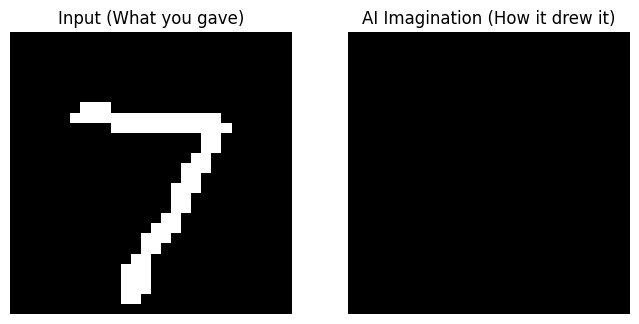

In [73]:
import cv2
import matplotlib.animation as animation

def save_ink_gif(generated_video, ref_image, filename="final_ink_writing.gif"):
    # generated_video: (16, 28, 28) float [-1, 1]
    
    # 1. Reverse frames (Empty -> Full)
    frames = generated_video[::-1]
    
    # 2. Scale to 0-255
    frames_uint8 = ((frames + 1) / 2 * 255).astype(np.uint8)
    ref_uint8 = ((ref_image + 1) / 2 * 255).astype(np.uint8)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.set_title("Input (What you gave)")
    ax2.set_title("AI Imagination (How it drew it)")
    ax1.axis('off')
    ax2.axis('off')
    
    ims = []
    for frame in frames_uint8:
        # --- THE POLISH ---
        # Any pixel < 100 becomes 0 (Black), > 100 becomes 255 (White)
        # This cleans up the "gray haze" background
        _, clean_frame = cv2.threshold(frame, 100, 255, cv2.THRESH_BINARY)
        
        # Optional: Dilate slightly to make stroke look thicker
        # clean_frame = cv2.dilate(clean_frame, np.ones((2,2), np.uint8))
        
        im1 = ax1.imshow(ref_uint8, cmap='gray', animated=True)
        im2 = ax2.imshow(clean_frame, cmap='gray', animated=True)
        ims.append([im1, im2])

    ani = animation.ArtistAnimation(fig, ims, interval=120, blit=True, repeat_delay=2000)
    ani.save(filename, writer='pillow')
    print(f"Saved: {filename}")
    return filename

# Run it on your working result!
save_ink_gif(generated_video, ref_image)

Saved smoothed video: hq_smooth_writing.gif


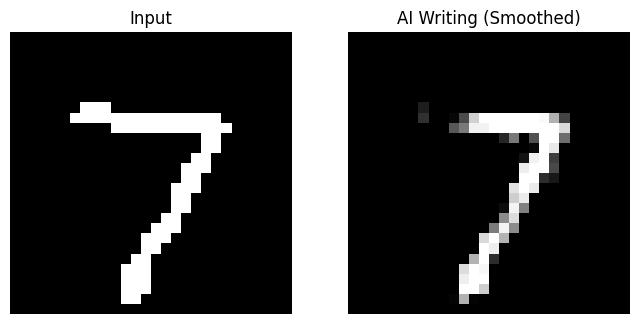

In [77]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def smooth_ink_video(generated_video, ref_image, filename="hq_smooth_writing.gif"):
    # generated_video: (16, 28, 28)
    
    # 1. Temporal Interpolation (16 frames -> 64 frames)
    # We zoom the Time axis by 4x. This makes the motion butter-smooth.
    # (Zoom factor: Time=4, H=1, W=1)
    smooth_video = scipy.ndimage.zoom(generated_video, (4, 1, 1), order=1)
    
    # 2. Reverse (Empty -> Full)
    frames = smooth_video[::1]
    
    # 3. Scale to 0-255
    frames_uint8 = ((frames + 1) / 2 * 255).astype(np.float32)
    ref_uint8 = ((ref_image + 1) / 2 * 255).astype(np.uint8)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.set_title("Input")
    ax2.set_title("AI Writing (Smoothed)")
    ax1.axis('off')
    ax2.axis('off')
    
    ims = []
    for frame in frames_uint8:
        # --- SOFT INK LOGIC ---
        # Instead of a hard threshold (clean_frame > 100), we use a "Soft Ramp".
        # This makes the ink look like it's soaking into the paper.
        
        # 1. Blur slightly to connect pixel gaps
        blurred = scipy.ndimage.gaussian_filter(frame, sigma=0.5)
        
        # 2. Apply a "Sigmoid-like" contrast curve
        # (This pushes grays to black/white but keeps the edges soft)
        clean_frame = np.clip((blurred - 50) * 1.5, 0, 255).astype(np.uint8)
        
        im1 = ax1.imshow(ref_uint8, cmap='gray', animated=True)
        im2 = ax2.imshow(clean_frame, cmap='gray', animated=True)
        ims.append([im1, im2])

    # Faster interval because we have 4x more frames
    ani = animation.ArtistAnimation(fig, ims, interval=30, blit=True)
    ani.save(filename, writer='pillow')
    print(f"Saved smoothed video: {filename}")

# Run on the SAME generated_video you just made
smooth_ink_video(generated_video, ref_image)

Generating Masked Animation for Digit 7...


Writing: 100%|██████████| 1000/1000 [00:04<00:00, 238.12it/s]


Saved smoothed video: masked_clean_writing.gif


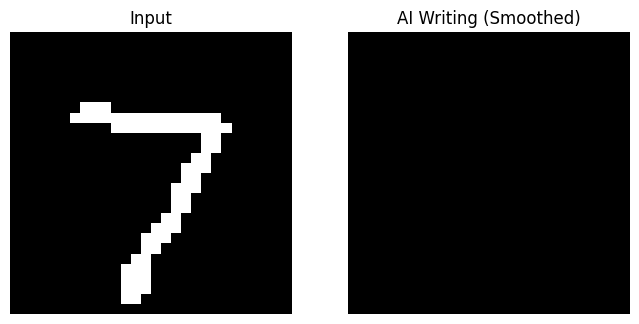

In [75]:
@torch.no_grad()
def generate_masked_writing(model, digit_index=None):
    # 1. Setup (Same as before)
    test_ds = DirectionalMNISTDataset(train=False) # Or Cached...
    
    if digit_index is None:
        for i in range(len(test_ds)):
            _, label = test_ds[i]
            if label == 7:
                digit_index = i
                break
                
    video_tensor, label = test_ds[digit_index]
    ref_frame = video_tensor[:, -1, :, :].to(device) # The Final Digit
    
    # --- 2. Create the Mask ---
    # Anywhere the final image has ink (> -0.9), the mask is 1. 
    # Anywhere it is black, the mask is 0.
    # (Images are normalized -1 to 1, so -0.9 is close to black)
    ink_mask = (ref_frame > -0.9).float().unsqueeze(1).repeat(1, 16, 1, 1)
    
    condition = ref_frame.unsqueeze(1).repeat(1, 16, 1, 1).unsqueeze(0)
    x = torch.randn((1, 1, 16, 28, 28)).to(device)
    
    # Move schedules
    alpha_gpu = alpha.to(device)
    alpha_bar_gpu = alpha_bar.to(device)
    beta_gpu = beta.to(device)

    print(f"Generating Masked Animation for Digit {label}...")
    
    for i in tqdm(reversed(range(1000)), total=1000, desc="Writing"):
        t = torch.tensor([i]).to(device)
        
        # Standard Prediction
        model_input = torch.cat([x, condition], dim=1)
        eps_theta = model(model_input, t)
        
        a_t = alpha_gpu[i].view(1,1,1,1,1)
        ab_t = alpha_bar_gpu[i].view(1,1,1,1,1)
        b_t = beta_gpu[i].view(1,1,1,1,1)
        
        mean = (1 / torch.sqrt(a_t)) * (x - (b_t / torch.sqrt(1 - ab_t)) * eps_theta)
        
        if i > 0:
            z = torch.randn_like(x)
            x_new = mean + torch.sqrt(b_t) * z
        else:
            x_new = mean
            
        # --- THE FIX: APPLY MASK ---
        # We enforce that pixels outside the final digit shape MUST be -1 (Black)
        # Inside the digit, we let the diffusion model decide (x_new)
        # Outside the digit, we force it to -1
        x = x_new * ink_mask + (1 - ink_mask) * -1.0

    return x.clamp(-1, 1).cpu().squeeze().numpy(), ref_frame.cpu().squeeze().numpy()

# Run it
clean_video, ref = generate_masked_writing(model)

# Save using your super-smoother
smooth_ink_video(clean_video, ref, filename="masked_clean_writing.gif")